In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import wandb

In [2]:
path1 = '../Data/car_dataset/HY_현대/'
path2 = '../Data/car_dataset/KI_기아/'
path3 = '../Data/car_dataset/GE_제네시스/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path1):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])

for folder, subfolders, filenames in os.walk(path2):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])
        
for folder, subfolders, filenames in os.walk(path3):
    for img in filenames:
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:15])
        
        
print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  180593
Image_labels: 180593


In [2]:
#path = '../Data/car_dataset_sample/'
path = '../Data/car_dataset/'
#path = '../../disk/data/car_dataset/'
img_names = []
img_labels = []

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        # if img[24] == 'P':
        #     continue
        img_names.append(folder+'/'+img)
        img_labels.append(img[9:18])
            
print('Images: ',len(img_names))
print("Image_labels:", len(img_labels))

Images:  290405
Image_labels: 290405


In [3]:
from sklearn.preprocessing import LabelEncoder


trn_df = pd.DataFrame(img_names, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
#trn_df['label'] = img_labels

label_value = []
for i, di in enumerate(trn_df['dir']):
    dir_l = di[23:-7].split('_')
    dir_v = dir_l[0][:-3] + dir_l[1]
    label_value.append(dir_v)

trn_df['label'] = label_value
train = trn_df
train

,image_id,dir,label
0,C_211206_HY_025_18_BL_A_P_01_054.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
1,C_211206_HY_025_18_BL_A_P_01_048.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
2,C_211206_HY_025_18_BL_A_T_02_005.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
3,C_211206_HY_025_18_BL_A_P_01_025.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
4,C_211206_HY_025_18_BL_A_T_03_001.jpg,../Data/car_dataset/HY_현대/025_i30/2018_파랑_트림A,현대/i30/2018
...,...,...,...
180588,C_211014_GE_018_20_BL_A_T_03_014.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020
180589,C_211014_GE_018_20_BL_A_T_03_009.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020
180590,C_211014_GE_018_20_BL_A_P_01_062.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020
180591,C_211014_GE_018_20_BL_A_P_01_016.jpg,../Data/car_dataset/GE_제네시스/018_G70/2020_파랑_트림A,제네시스/G70/2020


In [4]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

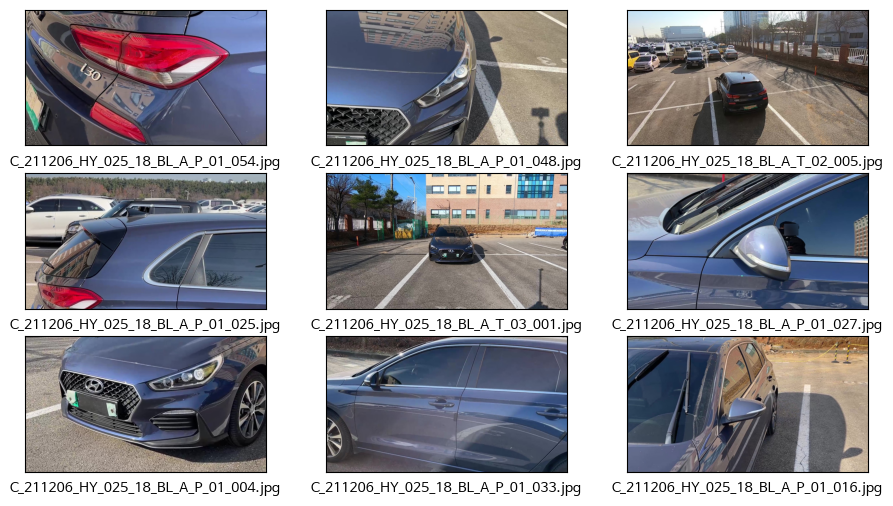

In [5]:
# Show images and labels

plt.figure(figsize=(11,6))
for i in range(9):
    path =train['dir'][i+5] +'/'+ train['image_id'][i] 
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    plt.imshow(im_rgb, cmap=plt.cm.binary)
    plt.xlabel(train['image_id'][i])
plt.show()

In [6]:
train['label'].value_counts()

현대/코나/2018         2755
기아/모닝/2017         2721
기아/K3/2019         2563
기아/스포티지/2018       2471
제네시스/G80/2018      2431
                   ... 
현대/아이오닉/2021        182
제네시스/EQ900/2019      95
현대/벨로스터/2021         95
현대/벨로스터/2017         95
기아/셀토스/2018          95
Name: label, Length: 160, dtype: int64

In [7]:
train['label'].value_counts().loc[lambda x : x > 900]

현대/코나/2018       2755
기아/모닝/2017       2721
기아/K3/2019       2563
기아/스포티지/2018     2471
제네시스/G80/2018    2431
                 ... 
현대/코나/2020        940
기아/니로/2018        940
현대/스타렉스/2020      937
현대/팰리세이드/2020     935
기아/니로/2019        923
Name: label, Length: 95, dtype: int64

In [8]:
low_data = train['label'].value_counts().loc[lambda x : x < 900].index

low_data = low_data.sort_values()
low_data

# for i, label in enumerate(train['label']):
#     #print(label)
#     if any(j in label for j in low_data) :
#         train.drop(i)
# train['label'].value_counts()

Index(['기아/K5/2021', '기아/K7/2021', '기아/K9/2017', '기아/K9/2018', '기아/니로/2021',
       '기아/레이/2021', '기아/모하비/2019', '기아/모하비/2020', '기아/모하비/2021',
       '기아/봉고3/2018', '기아/봉고3/2019', '기아/봉고3/2020', '기아/봉고3/2021',
       '기아/셀토스/2018', '기아/셀토스/2019', '기아/셀토스/2020', '기아/스토닉/2017',
       '기아/스토닉/2020', '기아/스토닉/2021', '기아/스팅어/2017', '기아/스팅어/2021',
       '기아/스포티지/2020', '기아/스포티지/2021', '기아/쏘울/2017', '기아/쏘울/2018',
       '기아/쏘울/2019', '기아/카니발/2021', '제네시스/EQ900/2019', '제네시스/G70/2020',
       '제네시스/G70/2021', '제네시스/G80/2020', '제네시스/G90/2020', '제네시스/G90/2021',
       '제네시스/GV80/2020', '제네시스/GV80/2021', '현대/i30/2017', '현대/i30/2018',
       '현대/i30/2019', '현대/넥쏘/2020', '현대/맥스크루즈/2017', '현대/맥스크루즈/2018',
       '현대/베뉴/2019', '현대/베뉴/2021', '현대/벨로스터/2017', '현대/벨로스터/2018',
       '현대/벨로스터/2019', '현대/벨로스터/2020', '현대/벨로스터/2021', '현대/스타렉스/2021',
       '현대/싼타페/2021', '현대/아이오닉/2017', '현대/아이오닉/2018', '현대/아이오닉/2019',
       '현대/아이오닉/2020', '현대/아이오닉/2021', '현대/엑센트/2017', '현대/엑센트/2018',
       '현대/엑센트/2019', 

In [9]:
# 해당 라벨과 일치하는 인덱스(열) 삭제
for i in range(len(low_data)):
    idx = train[train['label'] == low_data[i]].index
    train.drop(idx, inplace=True)
train.reset_index(inplace=True, drop=True)
train
# idx

,image_id,dir,label
0,C_210811_HY_053_20_WH_A_P_01_058.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
1,C_211206_HY_053_20_WH_A_P_01_014.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
2,C_211206_HY_053_20_WH_A_T_02_012.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
3,C_210811_HY_053_20_WH_A_P_01_024.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
4,C_211206_HY_053_20_WH_A_T_02_011.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,현대/베뉴/2020
...,...,...,...
148799,C_211129_GE_018_18_WH_C_P_01_034.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018
148800,C_211129_GE_018_18_WH_C_P_01_026.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018
148801,C_211129_GE_018_18_WH_C_P_01_025.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018
148802,C_211129_GE_018_18_WH_C_P_01_023.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,제네시스/G70/2018


In [10]:
train['label'].value_counts()

현대/코나/2018       2755
기아/모닝/2017       2721
기아/K3/2019       2563
기아/스포티지/2018     2471
제네시스/G80/2018    2431
                 ... 
기아/니로/2018        940
현대/코나/2020        940
현대/스타렉스/2020      937
현대/팰리세이드/2020     935
기아/니로/2019        923
Name: label, Length: 95, dtype: int64

In [11]:
print(len(train.label))

148804


In [12]:
train.label.nunique()

95

In [13]:
label_value = train['label'].values
label_value

array(['현대/베뉴/2020', '현대/베뉴/2020', '현대/베뉴/2020', ..., '제네시스/G70/2018',
       '제네시스/G70/2018', '제네시스/G70/2018'], dtype=object)

In [14]:
# 라벨인코더 선언 및 Fitting
le = LabelEncoder()
le.fit(label_value)

# 인코딩한 데이터로 변환
le_encoded = le.transform(label_value)

#결과물을 확인하면 array 형태로 나옵니다.
# 아래는 라벨 인코딩으로 만들어낸 데이터를 데이터 프레임으로 만들어주는 코드입니다.
new_cat = pd.DataFrame(le_encoded, columns = ['result'])
train['label'] = new_cat
train

,image_id,dir,label
0,C_210811_HY_053_20_WH_A_P_01_058.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
1,C_211206_HY_053_20_WH_A_P_01_014.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
2,C_211206_HY_053_20_WH_A_T_02_012.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
3,C_210811_HY_053_20_WH_A_P_01_024.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
4,C_211206_HY_053_20_WH_A_T_02_011.jpg,../Data/car_dataset/HY_현대/053_베뉴/2020_흰색_트림A,65
...,...,...,...
148799,C_211129_GE_018_18_WH_C_P_01_034.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53
148800,C_211129_GE_018_18_WH_C_P_01_026.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53
148801,C_211129_GE_018_18_WH_C_P_01_025.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53
148802,C_211129_GE_018_18_WH_C_P_01_023.jpg,../Data/car_dataset/GE_제네시스/018_G70/2018_흰색_트림C,53


In [15]:
le.classes_

array(['기아/K3/2017', '기아/K3/2018', '기아/K3/2019', '기아/K3/2020',
       '기아/K3/2021', '기아/K5/2017', '기아/K5/2018', '기아/K5/2019',
       '기아/K5/2020', '기아/K7/2017', '기아/K7/2018', '기아/K7/2019',
       '기아/K7/2020', '기아/K9/2019', '기아/K9/2020', '기아/K9/2021',
       '기아/니로/2017', '기아/니로/2018', '기아/니로/2019', '기아/니로/2020',
       '기아/레이/2017', '기아/레이/2018', '기아/레이/2019', '기아/레이/2020',
       '기아/모닝/2017', '기아/모닝/2018', '기아/모닝/2019', '기아/모닝/2020',
       '기아/모닝/2021', '기아/모하비/2017', '기아/모하비/2018', '기아/봉고3/2017',
       '기아/셀토스/2021', '기아/스토닉/2018', '기아/스토닉/2019', '기아/스팅어/2018',
       '기아/스팅어/2019', '기아/스팅어/2020', '기아/스포티지/2017', '기아/스포티지/2018',
       '기아/스포티지/2019', '기아/쏘렌토/2017', '기아/쏘렌토/2018', '기아/쏘렌토/2019',
       '기아/쏘렌토/2020', '기아/쏘렌토/2021', '기아/카니발/2017', '기아/카니발/2018',
       '기아/카니발/2019', '기아/카니발/2020', '제네시스/EQ900/2017', '제네시스/EQ900/2018',
       '제네시스/G70/2017', '제네시스/G70/2018', '제네시스/G70/2019', '제네시스/G80/2017',
       '제네시스/G80/2018', '제네시스/G80/2019', '제네시스/G80/2021', '제네시스/G90/2019

In [23]:
dist.destroy_process_group()

In [16]:
project_name = 'ef_ns04_HK_01'
user = 'hojunking'
run_name = 'ef_ns04_HK_01'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Training start with epoch 40 



/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/apex/__init__.py:68: DeprecatedFeatureWarning: apex.parallel.DistributedDataParallel is deprecated and will be removed by the end of February 2023.
  warnings.warn(msg, DeprecatedFeatureWarning)
epoch 0 loss: 0.8579: 100%|█████████████████| 8725/8725 [46:01<00:00,  3.16it/s]

train accuracy = 0.49880
[[1247  285  102 ...    0    1    7]
 [ 422  763  141 ...    0    1    4]
 [  98  199  759 ...    0    2    7]
 ...
 [   2    0    2 ... 1178  412   18]
 [   5    0    2 ...  492 1002   19]
 [   3    0    1 ...    5    2 1892]]



epoch 0 loss: 0.9199: 100%|█████████████████| 1861/1861 [04:53<00:00,  6.34it/s]


validation accuracy = 0.61644
[[189  60  21 ...   0   0   0]
 [ 22 173  11 ...   0   0   0]
 [  1  61 262 ...   0   0   0]
 ...
 [  0   0   0 ... 103  42   0]
 [  0   0   0 ...  44 134   1]
 [  0   0   0 ...   0   0 215]]


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/wandb/sdk/data_types/image.py:262: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  util.ensure_matplotlib_figure(data).savefig(buf)
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


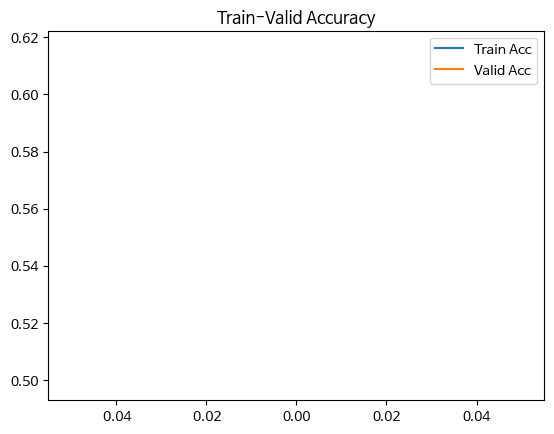

epoch 1 loss: 0.5205: 100%|█████████████████| 8725/8725 [44:37<00:00,  3.26it/s]

train accuracy = 0.75262
[[1847  157   68 ...    0    0    0]
 [ 209 1614  117 ...    2    1    0]
 [  39  174 1363 ...    1    1    0]
 ...
 [   0    1    0 ... 1788  237    0]
 [   0    0    0 ...  359 1561    1]
 [   0    0    0 ...    1    0 2145]]



epoch 1 loss: 4.1867: 100%|█████████████████| 1861/1861 [04:46<00:00,  6.48it/s]


validation accuracy = 0.71150
[[260  20  10 ...   0   0   0]
 [ 30 188   8 ...   0   1   0]
 [  5  56 273 ...   0   0   0]
 ...
 [  0   0   0 ... 158  11   0]
 [  0   0   0 ...  64 138   1]
 [  0   0   0 ...   0   0 211]]


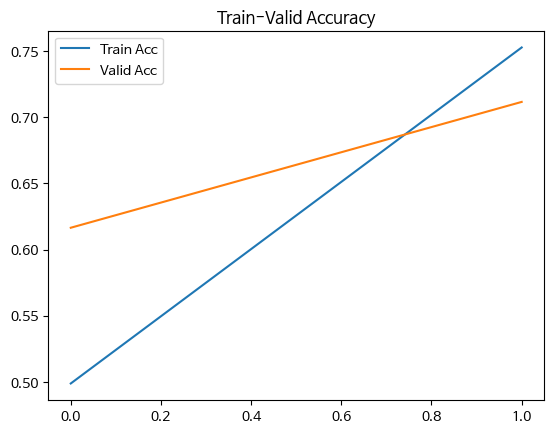

EarlyStopping counter: 1 out of 8
Best valid loss from now: 0.9199838288129502


epoch 2 loss: 0.3704: 100%|█████████████████| 8725/8725 [44:10<00:00,  3.29it/s]

train accuracy = 0.85159
[[2005  104   35 ...    0    0    0]
 [  93 1885  100 ...    0    1    0]
 [  29  141 1669 ...    0    0    0]
 ...
 [   0    0    0 ... 1993  143    1]
 [   0    0    1 ...  178 1898    0]
 [   0    0    0 ...    0    0 2169]]



epoch 2 loss: 3.5070: 100%|█████████████████| 1861/1861 [04:30<00:00,  6.88it/s]


validation accuracy = 0.76234
[[248  26  11 ...   0   0   0]
 [ 13 192   9 ...   0   1   0]
 [  6  34 337 ...   0   0   0]
 ...
 [  0   0   0 ... 138  23   0]
 [  0   0   0 ...  26 181   2]
 [  0   0   0 ...   0   0 214]]


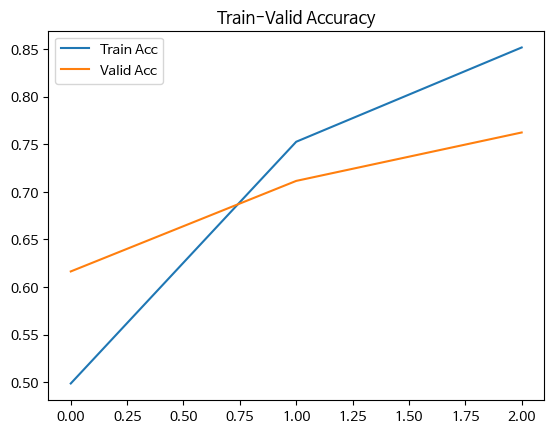

EarlyStopping counter: 2 out of 8
Best valid loss from now: 0.9199838288129502


epoch 3 loss: 0.2624: 100%|█████████████████| 8725/8725 [44:11<00:00,  3.29it/s]

train accuracy = 0.90107
[[2100   51   16 ...    0    0    0]
 [  44 2002   83 ...    0    0    0]
 [  24  136 1781 ...    0    0    0]
 ...
 [   0    0    0 ... 2077   84    0]
 [   0    0    0 ...  100 2025    0]
 [   0    0    0 ...    1    0 2176]]



epoch 3 loss: 0.6650: 100%|█████████████████| 1861/1861 [04:30<00:00,  6.87it/s]


validation accuracy = 0.78801
[[265  16   7 ...   0   0   0]
 [  8 203  25 ...   0   1   0]
 [  8  46 377 ...   0   0   0]
 ...
 [  0   0   0 ... 147  24   1]
 [  0   0   0 ...  21 186   0]
 [  0   0   0 ...   0   0 215]]


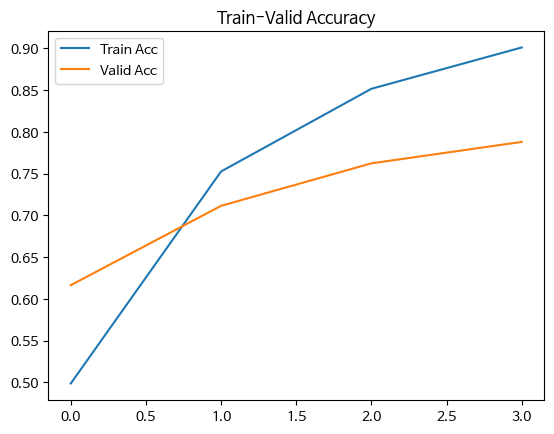

epoch 4 loss: 0.2043: 100%|█████████████████| 8725/8725 [44:14<00:00,  3.29it/s]

train accuracy = 0.92773
[[2129   36   19 ...    0    0    0]
 [  35 2049   65 ...    0    1    0]
 [  15   79 1918 ...    0    0    0]
 ...
 [   0    0    0 ... 2114   48    0]
 [   0    0    0 ...   72 2082    0]
 [   0    0    0 ...    0    0 2184]]



epoch 4 loss: 0.6912: 100%|█████████████████| 1861/1861 [04:30<00:00,  6.87it/s]


validation accuracy = 0.79446
[[268  12   8 ...   0   0   0]
 [ 13 215  11 ...   0   1   0]
 [  7  79 353 ...   0   0   1]
 ...
 [  0   0   0 ... 150  25   0]
 [  0   0   0 ...  16 195   1]
 [  0   0   0 ...   0   0 209]]


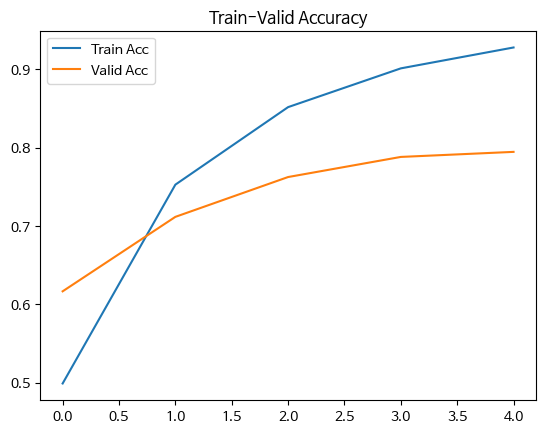

EarlyStopping counter: 1 out of 8
Best valid loss from now: 0.6646847440917345


epoch 5 loss: 0.1643: 100%|█████████████████| 8725/8725 [44:14<00:00,  3.29it/s]

train accuracy = 0.94396
[[2143   31   10 ...    0    0    0]
 [  32 2082   48 ...    0    1    0]
 [   4   68 1976 ...    0    0    0]
 ...
 [   0    0    0 ... 2126   51    0]
 [   0    0    0 ...   54 2110    0]
 [   0    0    0 ...    0    0 2183]]



epoch 5 loss: 0.6859: 100%|█████████████████| 1861/1861 [04:31<00:00,  6.86it/s]


validation accuracy = 0.80720
[[268   7  11 ...   0   0   0]
 [ 15 198  28 ...   0   1   1]
 [  3  40 396 ...   0   0   1]
 ...
 [  0   0   0 ... 141  28   0]
 [  0   0   0 ...  20 199   0]
 [  0   0   0 ...   0   1 214]]


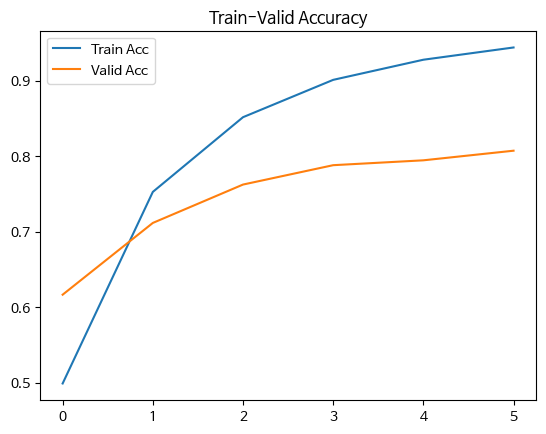

EarlyStopping counter: 2 out of 8
Best valid loss from now: 0.6646847440917345


epoch 6 loss: 0.1456: 100%|█████████████████| 8725/8725 [44:14<00:00,  3.29it/s]

train accuracy = 0.95426
[[2142   27   18 ...    0    0    0]
 [  22 2106   48 ...    0    0    0]
 [  16   58 2004 ...    0    0    0]
 ...
 [   0    0    0 ... 2145   37    0]
 [   0    0    0 ...   37 2135    0]
 [   0    0    0 ...    0    0 2192]]



epoch 6 loss: 0.6940: 100%|█████████████████| 1861/1861 [04:32<00:00,  6.84it/s]


validation accuracy = 0.81180
[[264   8  16 ...   0   0   0]
 [ 23 200  25 ...   0   1   0]
 [  5  48 420 ...   0   0   0]
 ...
 [  0   0   0 ... 136  26   0]
 [  0   0   0 ...  11 198   0]
 [  0   0   0 ...   0   0 207]]


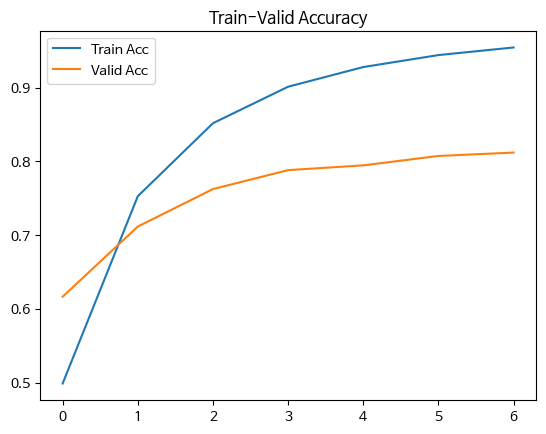

EarlyStopping counter: 3 out of 8
Best valid loss from now: 0.6646847440917345


epoch 7 loss: 0.1133: 100%|█████████████████| 8725/8725 [44:15<00:00,  3.29it/s]

train accuracy = 0.96130
[[2162   20    7 ...    0    0    0]
 [  23 2107   42 ...    0    0    0]
 [   8   53 2045 ...    0    0    0]
 ...
 [   0    0    0 ... 2153   37    0]
 [   0    0    0 ...   38 2140    0]
 [   0    0    0 ...    1    0 2185]]



epoch 7 loss: 0.7168: 100%|█████████████████| 1861/1861 [04:32<00:00,  6.84it/s]


validation accuracy = 0.81886
[[277   4   6 ...   0   0   0]
 [ 19 194  26 ...   0   1   0]
 [  8  35 394 ...   0   0   0]
 ...
 [  0   0   0 ... 158  14   0]
 [  0   0   0 ...  25 190   1]
 [  0   0   0 ...   0   0 212]]


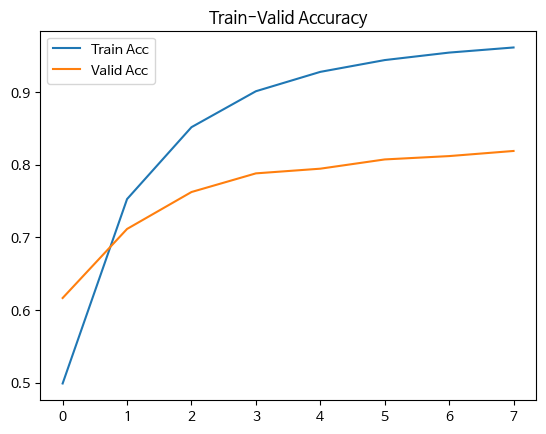

EarlyStopping counter: 4 out of 8
Best valid loss from now: 0.6646847440917345


epoch 8 loss: 0.1143: 100%|█████████████████| 8725/8725 [44:11<00:00,  3.29it/s]

train accuracy = 0.96630
[[2166   14    7 ...    0    0    0]
 [  13 2127   42 ...    0    0    0]
 [   4   47 2070 ...    0    0    0]
 ...
 [   0    0    0 ... 2155   35    0]
 [   0    0    0 ...   35 2143    0]
 [   0    0    0 ...    0    0 2189]]



epoch 8 loss: 0.6948: 100%|█████████████████| 1861/1861 [04:31<00:00,  6.86it/s]


validation accuracy = 0.82477
[[284   2   7 ...   0   0   0]
 [ 19 207  20 ...   0   1   0]
 [ 11  38 370 ...   0   0   0]
 ...
 [  0   0   0 ... 153  20   0]
 [  0   0   0 ...  21 203   1]
 [  0   0   0 ...   0   0 214]]


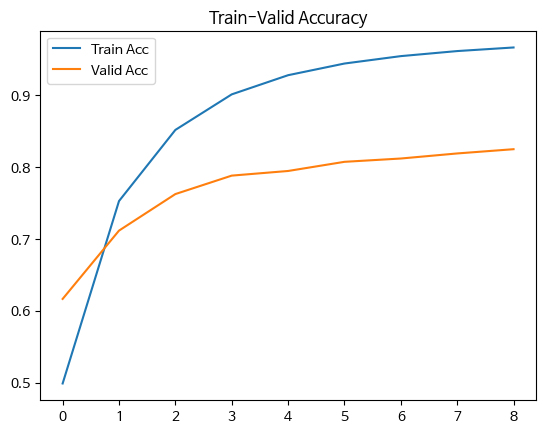

EarlyStopping counter: 5 out of 8
Best valid loss from now: 0.6646847440917345


epoch 9 loss: 0.0963: 100%|█████████████████| 8725/8725 [44:13<00:00,  3.29it/s]

train accuracy = 0.97074
[[2165   18    9 ...    0    0    0]
 [  15 2140   30 ...    0    0    0]
 [  10   39 2087 ...    1    0    0]
 ...
 [   0    0    0 ... 2168   19    0]
 [   0    0    0 ...   18 2168    0]
 [   0    0    0 ...    1    0 2190]]



epoch 9 loss: 0.7522: 100%|█████████████████| 1861/1861 [04:31<00:00,  6.84it/s]


validation accuracy = 0.82302
[[280   6   3 ...   0   0   0]
 [ 14 204  21 ...   0   0   0]
 [  6  54 382 ...   0   0   0]
 ...
 [  0   0   0 ... 147  24   0]
 [  1   0   0 ...  20 191   0]
 [  0   0   0 ...   0   0 218]]


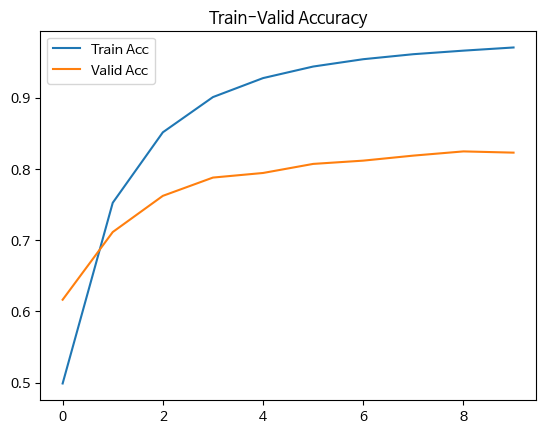

EarlyStopping counter: 6 out of 8
Best valid loss from now: 0.6646847440917345


epoch 10 loss: 0.0906: 100%|████████████████| 8725/8725 [44:13<00:00,  3.29it/s]

train accuracy = 0.97362
[[2170   10    6 ...    0    0    0]
 [  15 2145   27 ...    0    0    0]
 [   6   30 2086 ...    0    0    0]
 ...
 [   0    0    0 ... 2165   20    0]
 [   0    0    0 ...   19 2164    0]
 [   0    0    0 ...    0    0 2198]]



epoch 10 loss: 0.7297: 100%|████████████████| 1861/1861 [04:32<00:00,  6.83it/s]


validation accuracy = 0.82911
[[270  10  11 ...   0   0   0]
 [  7 225  15 ...   0   1   0]
 [  2  63 391 ...   0   0   0]
 ...
 [  0   0   0 ... 167  11   0]
 [  0   0   0 ...  32 186   0]
 [  0   0   0 ...   0   0 219]]


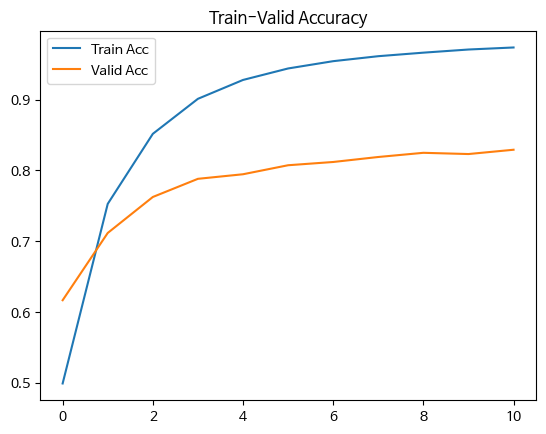

EarlyStopping counter: 7 out of 8
Best valid loss from now: 0.6646847440917345


epoch 11 loss: 0.0873: 100%|████████████████| 8725/8725 [44:17<00:00,  3.28it/s]

train accuracy = 0.97578
[[2182    9    4 ...    0    0    0]
 [  15 2154   23 ...    0    0    0]
 [   4   28 2105 ...    0    0    0]
 ...
 [   0    0    0 ... 2173   19    0]
 [   0    0    0 ...   22 2164    0]
 [   0    0    0 ...    0    0 2194]]



epoch 11 loss: 0.7595: 100%|████████████████| 1861/1861 [04:32<00:00,  6.83it/s]


validation accuracy = 0.82480
[[273  14   2 ...   0   0   0]
 [  6 212  21 ...   0   1   0]
 [  5  42 339 ...   0   0   0]
 ...
 [  0   0   0 ... 150  23   0]
 [  1   0   0 ...  16 203   0]
 [  0   0   0 ...   0   0 220]]


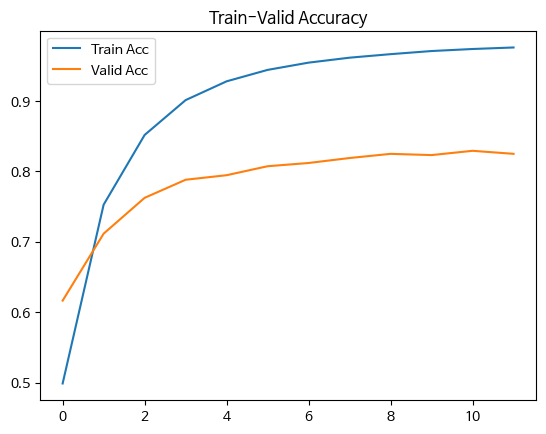

EarlyStopping counter: 8 out of 8
Best valid loss from now: 0.6646847440917345
stop called
time : 9:48:05
Best Epoch : 10/ 12
Best Train Accuracy : 0.97362
[[2170   10    6 ...    0    0    0]
 [  15 2145   27 ...    0    0    0]
 [   6   30 2086 ...    0    0    0]
 ...
 [   0    0    0 ... 2165   20    0]
 [   0    0    0 ...   19 2164    0]
 [   0    0    0 ...    0    0 2198]]
Best Valid Accuracy : 0.82911
[[270  10  11 ...   0   0   0]
 [  7 225  15 ...   0   1   0]
 [  2  63 391 ...   0   0   0]
 ...
 [  0   0   0 ... 167  11   0]
 [  0   0   0 ...  32 186   0]
 [  0   0   0 ...   0   0 219]]


In [17]:
%run classification_train_efficientnet2.ipynb

In [18]:
print(f'Best Epoch : {best_index}/ {len(valid_acc_list)}')
print(f'Best Train Accuracy : {train_acc_list[best_index]:.5f}')
print(train_matrix_list[best_index])
print(f'Best Valid Accuracy : {valid_acc_list[best_index]:.5f}')
print(valid_matrix_list[best_index])

Best Epoch : 38/ 40
Best Train Accuracy : 0.99712
[[2847    3    1 ...    0    0    0]
 [   4 2849    0 ...    0    0    0]
 [   3    1 2843 ...    0    0    0]
 ...
 [   0    0    0 ... 2848    3    0]
 [   0    0    0 ...    2 2849    0]
 [   0    0    0 ...    0    0 2852]]
Best Valid Accuracy : 0.88483
[[255  10   2 ...   0   0   0]
 [  6 196   0 ...   0   0   0]
 [  3   0 389 ...   0   0   0]
 ...
 [  0   0   0 ... 178   5   0]
 [  0   0   0 ...  12 208   0]
 [  0   0   0 ...   0   0 218]]


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: honbul. Use `wandb login --relogin` to force relogin


/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:26<00:00,  4.79it/s]


train accuracy = 0.98053
[[14778   222]
 [  362 14638]]


epoch 0 loss: 0.5145: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.92it/s]


validation accuracy = 0.81408
[[512 127]
 [  5  66]]


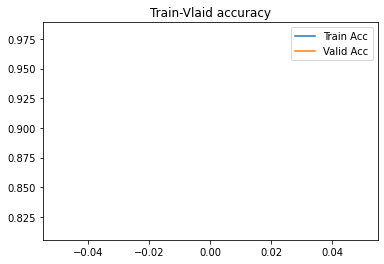

epoch 1 loss: 0.0124: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:25<00:00,  4.79it/s]


train accuracy = 0.99637
[[14946    54]
 [   55 14945]]


epoch 1 loss: 0.7367: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.10it/s]


validation accuracy = 0.70704
[[431 208]
 [  0  71]]


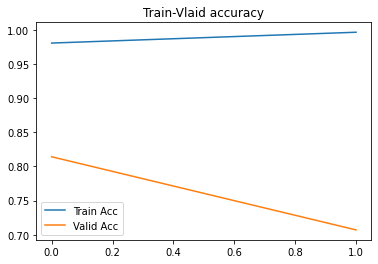

epoch 2 loss: 0.0020: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:30<00:00,  4.76it/s]


train accuracy = 0.99767
[[14959    41]
 [   29 14971]]


epoch 2 loss: 0.6676: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.18it/s]


validation accuracy = 0.80563
[[509 130]
 [  8  63]]


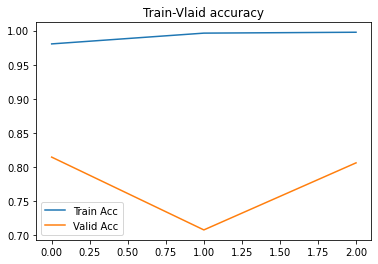

epoch 3 loss: 0.0028: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:31<00:00,  4.75it/s]


train accuracy = 0.99870
[[14980    20]
 [   19 14981]]


epoch 3 loss: 0.3945: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.96it/s]


validation accuracy = 0.85915
[[546  93]
 [  7  64]]


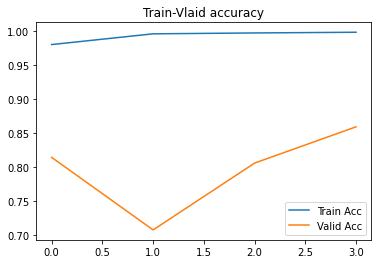

epoch 4 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:32<00:00,  4.74it/s]


train accuracy = 0.99773
[[14961    39]
 [   29 14971]]


epoch 4 loss: 0.3124: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.07it/s]


validation accuracy = 0.88169
[[569  70]
 [ 14  57]]


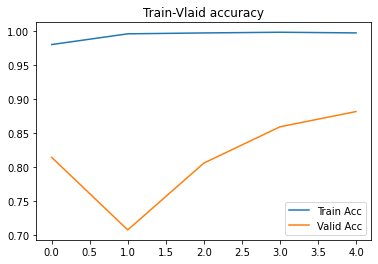

epoch 5 loss: 0.0049:  47%|██████████████████████████▊                              | 1413/3000 [04:58<05:23,  4.90it/s]

In [ ]:
%run classification_train_val_separate_efficientnet.ipynb